In [86]:
import pandas as pd
import numpy as np
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import  Dense, Dropout
import keras_nlp
from keras import backend as K
from keras import losses


import tensorflow_text as text
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import coral_ordinal as coral
import coral_ordinal as corn

In [23]:
data = pd.read_csv("learning-agency-lab-automated-essay-scoring-2/train.csv")

X_train, X_val, y_train, y_val = train_test_split(data['full_text'], data['score'], test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape )

(13845,) (3462,) (13845,) (3462,)


In [24]:
# labels for classifications
y_train = (y_train - 1).to_numpy()
y_val = (y_val - 1).to_numpy()

In [3]:
def ordinal(labels, num_classes):
    # Initialize an empty list to store the ordinal representation
    ordinal_rep = []
    
    # Iterate over each label in the input array
    for label in labels:
        # Create an array where the first `label` elements are 1, rest are 0
        ordinal_label = np.zeros(num_classes, dtype=int)
        ordinal_label[:label] = 1
        ordinal_rep.append(ordinal_label)
    
    # Convert the list to a numpy array and return
    return np.array(ordinal_rep)

In [4]:
# labels for classifications
y_train = ordinal(y_train, 6)
y_val = ordinal(y_val, 6)

In [5]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
# Convert to a dictionary with class indices as keys
class_weight_dict = dict(enumerate(class_weights))
# Print the computed class weights (optional)
print(class_weight_dict)

TypeError: unhashable type: 'numpy.ndarray'

In [25]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
# does tokanization, padding and truncation
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_small_en_uncased", trainable=False)
encoder_inputs = preprocessor(text_input)
encoder = keras_nlp.models.BertBackbone.from_preset("bert_small_en_uncased", load_weights=True, trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]  # Shape: [batch_size, 768]

In [26]:
for layer in encoder.layers:
    layer.trainable = False

In [27]:
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

In [9]:
class BiasLayer(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(BiasLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # Ensure the bias shape matches the last dimension of the input
        if input_shape[-1] != self.units:
            raise ValueError(f"Input shape mismatch: expected last dimension to be {self.units}, got {input_shape[-1]}")
        self.bias = self.add_weight(
            shape=(self.units,),  # Bias matches the number of units
            initializer='zeros',
            trainable=True,
            name='bias'
        )

    def call(self, inputs):
        # Add bias to inputs and apply activation
        output = inputs + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        # Output shape is the same as the input shape
        return input_shape

In [99]:
l = tf.keras.layers.Dense(32, activation='relu', name='h1')(pooled_output)
#l = tf.keras.layers.Dense(64, activation='relu',name='h2')(l)
#l = tf.keras.layers.Dense(32, activation='relu', name='h3')(l)
# l = tf.keras.layers.Dense(6, activation='relu', name='h4')(l)
# l = BiasLayer(6, activation='sigmoid', name='output')(l)
l = coral.CoralOrdinal(num_classes = 6)(l)

model=tf.keras.Model(inputs=[text_input], outputs=[l])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=coral.OrdinalCrossEntropy(),
              metrics=['accuracy'])
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_preprocessor_1 │ [(None, 512),     │          0 │ input_layer_1[0]… │
│ (BertPreprocessor)  │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 512),     │ 28,763,648 │ bert_preprocesso… │
│ (BertBackbone)      │ (None, 512, 512)] │            │ bert_preprocesso… │
│                     │                   │            │ bert_preprocesso… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h1 (Dense)          │ (None, 32)        │     16,416 │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coral_ordinal_13    │ (None, 5)         │         37 │ h1[0][0]          │
│ (CoralOrdinal)      │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,780,101 (109.79 MB)

 Trainable params: 16,453 (64.27 KB)

 Non-trainable params: 28,763,648 (109.72 MB)

In [107]:
set(y_train)

{0, 1, 2, 3, 4, 5}

In [100]:
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_val, y_val)) # , class_weight=class_weight_dict)
# model.evaluate(X_val, y_val)
# accuracy: 0.0777 - loss: 1.1673
# accuracy: 0.5426 - loss: 1.0492

Epoch 1/3
433/433 ━━━━━━━━━━━━━━━━━━━━ 236s 536ms/step - accuracy: 0.0744 - loss: 3.3459 - val_accuracy: 0.0751 - val_loss: 3.0698
Epoch 2/3
433/433 ━━━━━━━━━━━━━━━━━━━━ 230s 530ms/step - accuracy: 0.0737 - loss: 3.0833 - val_accuracy: 0.0751 - val_loss: 2.9808
Epoch 3/3
433/433 ━━━━━━━━━━━━━━━━━━━━ 228s 526ms/step - accuracy: 0.0722 - loss: 3.0058 - val_accuracy: 0.0751 - val_loss: 2.9036


In [101]:
preds_raw = model.predict(X_val) #[:, 0]

109/109 ━━━━━━━━━━━━━━━━━━━━ 41s 366ms/step


In [102]:
preds_raw[0:10]

array([[-0.34207037, -0.34852973, -0.5645625 , -0.595122  , -0.59656054],
       [ 0.6141652 ,  0.60770583,  0.39167303,  0.36111358,  0.359675  ],
       [-0.7238798 , -0.73033917, -0.9463719 , -0.9769314 , -0.97836995],
       [-1.2384626 , -1.2449219 , -1.4609547 , -1.4915141 , -1.4929527 ],
       [ 0.09201825,  0.08555889, -0.1304739 , -0.16103336, -0.16247194],
       [-0.33131936, -0.33777872, -0.5538115 , -0.584371  , -0.5858095 ],
       [-0.76303685, -0.7694962 , -0.98552895, -1.0160884 , -1.017527  ],
       [-1.4763163 , -1.4827757 , -1.6988084 , -1.7293679 , -1.7308065 ],
       [-0.27077618, -0.27723554, -0.4932683 , -0.5238278 , -0.52526635],
       [-0.14754763, -0.15400699, -0.37003976, -0.40059924, -0.4020378 ]],
      dtype=float32)

In [103]:
probs = pd.DataFrame(coral.ordinal_softmax(preds_raw).numpy())

In [104]:
probs # .sum(axis=1)

,0,1,2,3,4,5
0,0.584693,0.001568,0.051247,0.007032,0.000330,0.355131
1,0.351110,0.001473,0.050732,0.007375,0.000348,0.588962
2,0.673461,0.001419,0.045505,0.006114,0.000286,0.273215
3,0.775296,0.001123,0.035259,0.004627,0.000216,0.183479
4,0.477012,0.001612,0.053949,0.007599,0.000357,0.459471
...,...,...,...,...,...,...
3457,0.688567,0.001383,0.044227,0.005921,0.000277,0.259625
3458,0.853481,0.000806,0.024890,0.003209,0.000149,0.117465
3459,0.502904,0.001615,0.053742,0.007522,0.000353,0.433863
3460,0.826716,0.000923,0.028676,0.003719,0.000173,0.139792


In [105]:
preds = probs.idxmax(axis = 1)

In [106]:
set(preds)

{0, 5}

In [202]:
preds = preds_raw.argmax(axis=-1)

In [203]:
preds=preds_raw.sum(axis=-1)

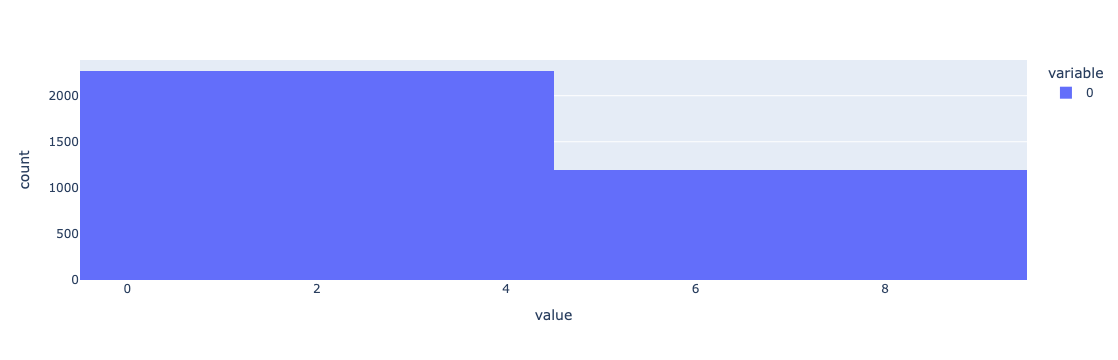

In [97]:
px.histogram(preds)

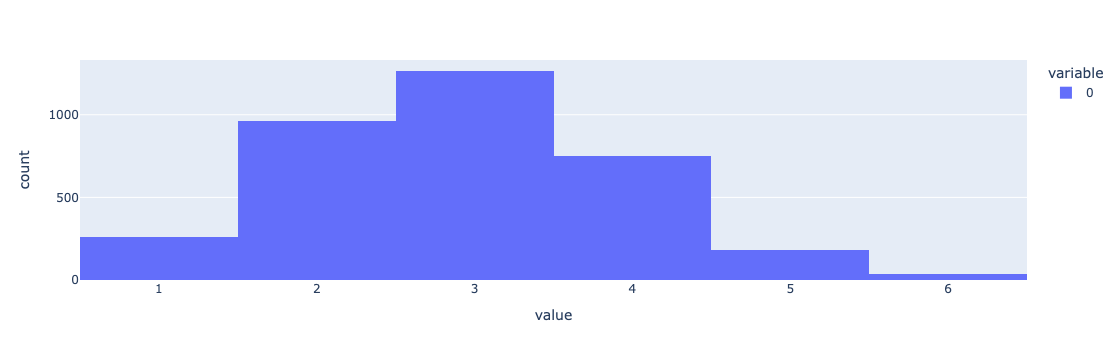

In [206]:
px.histogram(y_val.sum(axis=-1)) # y_val+1)

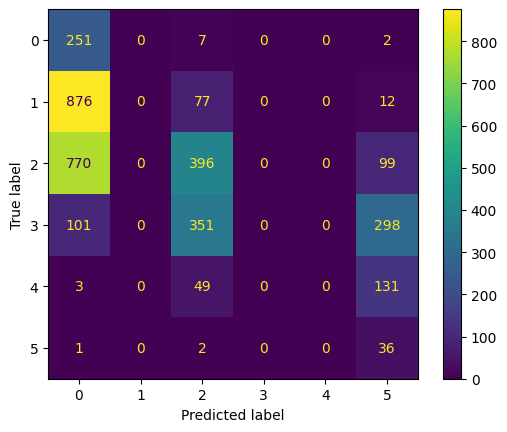

In [84]:
# Plot confusion matrix
cm = confusion_matrix(y_val, preds, labels=list(range(0,6)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(0,6)))
disp.plot()

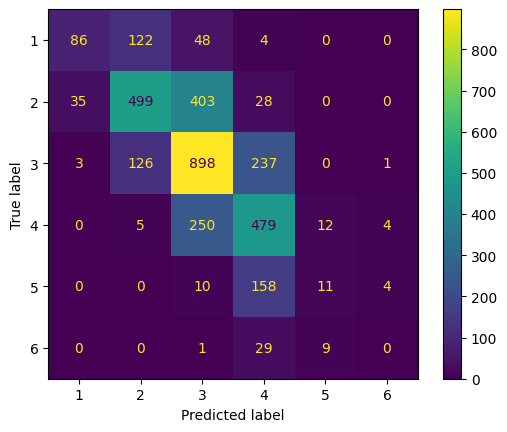

In [64]:
# Plot confusion matrix
cm = confusion_matrix(y_val+1, preds+1, labels=list(set(y_val+1)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(y_val+1)))
disp.plot()

In [15]:
print(np.mean(abs(preds - y_val)))
print(np.mean((np.round(preds, 0) - y_val)**2))

1.91231125951693
4.8272674754477185


In [16]:
print(min(preds), max(preds))

0.00030520812 0.9299879
